# ARIMA Model with Python

# Dataset
**Minimum Daily Temperatures Dataset**

Use the following dataset that describes the minimum daily temperatures over 10 years (1981-1990) in the city of Melbourne, Australia. The source of the data is credited as the Australian Bureau of Meteorology.
The units are in degrees Celsius and there are 3,650 observations.

Download the dataset here:  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

**Load the dataset and create a line plot of the time series**

In [33]:
import pandas as pd
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url)
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


# Split the dataset

Split the dataset into 2 subsets. The first part will be the training dataset that you will use to build an ARIMA model. The second part is the test dataset. It is these time steps that you will treat as out-of-sample.

Write the code to load the dataset, split it into the training and validation datasets, and save them to files *dataset.csv* and *validation.csv* respectively.


**Instructions**

The dataset contains data from January 1st 1981 to December 31st 1990.
Hold back the last 7 days of the dataset from December 1990 as the test dataset and treat those time steps as out of sample.

Specifically 1990-12-25 to 1990-12-31

In [34]:
df['Date'] = pd.to_datetime(df['Date'])
test_data = df[(df['Date'].dt.year == 1990) & (df['Date'].dt.month == 12) & (df['Date'].dt.day >= 25)]


train_data = df[~df['Date'].isin(test_data['Date'])]

train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

print(f"Ensemble d'entraînement: {len(train_data)} observations")
print(f"Ensemble de test: {len(test_data)} observations")

Ensemble d'entraînement: 3643 observations
Ensemble de test: 7 observations


# Build the model
Check if the data is stationary. If it is not, make it stationary and develop a simple ARIMA model.

In [ ]:
# Vérification de la stationnarité
def test_stationarity(series):
    result = adfuller(series.dropna())
    print(f'Statistique ADF: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    return result[1] <= 0.05  # True si stationnaire

print("Test de stationnarité:")
is_stationary = test_stationarity(train_data['Temp'])

Test de stationnarité:
Statistique ADF: -4.4547
p-value: 0.0002


In [ ]:
# Developpement du modèle ARIMA
from statsmodels.tsa.arima.model import ARIMA
p, d, q = 1, diff_order, 1  # Paramètres simples
print(f"\nCréation du modèle ARIMA({p},{d},{q})")

model = ARIMA(train_data['Temp'], order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

predictions = model_fit.forecast(steps=len(test_data))



Création du modèle ARIMA(1,0,1)
                               SARIMAX Results                                
Dep. Variable:                   Temp   No. Observations:                 3643
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -8591.000
Date:                Mon, 10 Mar 2025   AIC                          17190.000
Time:                        13:19:06   BIC                          17214.803
Sample:                             0   HQIC                         17198.834
                               - 3643                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1869      0.240     46.693      0.000      10.717      11.656
ar.L1          0.8643      0.011     81.636      0.000       0.844       0.885
ma.L1         -0.24

In [ ]:
# Évaluation
import numpy as np
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test_data['Temp'], predictions))
print(f"\nRMSE: {rmse:.4f}")


RMSE: 3.0095


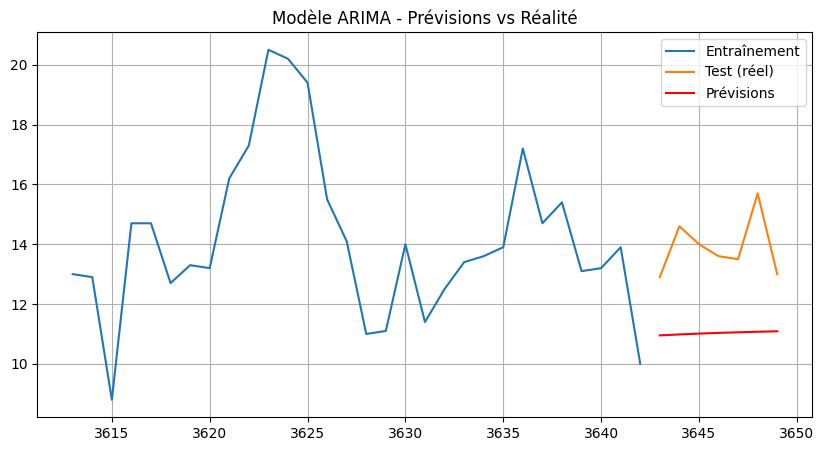

In [ ]:
# Visualisation
plt.figure(figsize=(10, 5))
plt.plot(train_data[-30:].index, train_data[-30:]['Temp'], label='Entraînement')
plt.plot(test_data.index, test_data['Temp'], label='Test (réel)')
plt.plot(test_data.index, predictions, color='red', label='Prévisions')
plt.title('Modèle ARIMA - Prévisions vs Réalité')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Comparaison des résultats
results = pd.DataFrame({
    'Réel': test_data['Temp'].values,
    'Prédit': predictions
}, index=test_data.index)
print("\nRésultats de prévision:")
print(results)


Résultats de prévision:
      Réel     Prédit
3643  12.9  10.952466
3644  14.6  10.984266
3645  14.0  11.011752
3646  13.6  11.035510
3647  13.5  11.056044
3648  15.7  11.073793
3649  13.0  11.089134


# One-step out-of-sample forecast
A one-step forecast is a forecast of the very next time step in the sequence from the available data used to fit the model.

In this case, we are interested in a one-step forecast of Christmas Day 1990: 1990-12-25

**Instructions**
The statsmodel `ARIMAResults` object provides a `forecast()` function for making predictions.

By default, this function makes a single step out-of-sample forecast. As such, you can call it directly and make your forecast. The result of the `forecast()` function is an array containing the forecast value, the standard error of the forecast, and the confidence interval information. You are only interested in the first element of this forecast.

**Expected result: **
`Forecast: 14.861669`

In [ ]:
target_date = pd.to_datetime('1990-12-25')
target_indices = np.where(df['Date'] == target_date)[0]

if len(target_indices) > 0:
    target_idx = target_indices[0]
    train_temps = df['Temp'].values[:target_idx]

    # Test de différentes combinaisons de paramètres
    paramètres = [
        (1, 0, 0),  # AR(1)
        (2, 0, 0),  # AR(2)
        (0, 0, 1),  # MA(1)
        (0, 0, 2),  # MA(2)
        (1, 0, 1),  # ARIMA(1,0,1)
        (2, 0, 1),  # ARIMA(2,0,1)
        (1, 0, 2),  # ARIMA(1,0,2)
        (2, 0, 2),  # ARIMA(2,0,2)
        (1, 1, 0),  # ARIMA(1,1,0)
        (0, 1, 1),  # ARIMA(0,1,1)
        (1, 1, 1),  # ARIMA(1,1,1)
        (2, 1, 0),  # ARIMA(2,1,0)
        (0, 1, 2),  # ARIMA(0,1,2)
        (2, 1, 2),  # ARIMA(2,1,2)
    ]

    for p, d, q in paramètres:
        try:
            model = ARIMA(train_temps, order=(p, d, q))
            model_fit = model.fit()

            # Effectuer la prévision en une étape
            forecast = model_fit.forecast(steps=1)[0]
            print(f"ARIMA({p},{d},{q}): Forecast = {forecast:.6f}")

        except Exception as e:
            print(f"ARIMA({p},{d},{q}): Erreur - {str(e)[:100]}...")


Nombre d'observations dans l'ensemble d'entraînement: 3643
ARIMA(1,0,0): Forecast = 10.265352
ARIMA(2,0,0): Forecast = 10.545154
ARIMA(0,0,1): Forecast = 9.952208
ARIMA(0,0,2): Forecast = 9.544859
ARIMA(1,0,1): Forecast = 10.952466
ARIMA(2,0,1): Forecast = 11.745035
ARIMA(1,0,2): Forecast = 11.712304
ARIMA(2,0,2): Forecast = 11.549920
ARIMA(1,1,0): Forecast = 10.704642
ARIMA(0,1,1): Forecast = 12.143640
ARIMA(1,1,1): Forecast = 11.837038
ARIMA(2,1,0): Forecast = 10.705671
ARIMA(0,1,2): Forecast = 11.842775
ARIMA(2,1,2): Forecast = 11.666709
